# Error Analysis for best Weighted Ensemble Model

In [89]:
import pandas as pd

# Load the predictions
predictions_all = pd.read_csv("../../data/preds/img3_preds.csv")
predictions_labeled = predictions_all[predictions_all["label"] != 0]

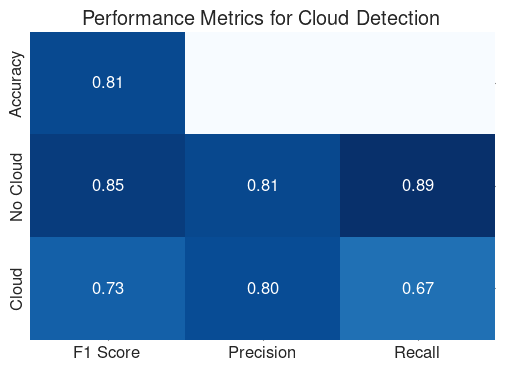

In [88]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate common classification metrics
precision_score_cloud = precision_score(predictions_labeled["label"], predictions_labeled["pred"], pos_label=1)
recall_score_cloud = recall_score(predictions_labeled["label"], predictions_labeled["pred"], pos_label=1)
f1_score_cloud = f1_score(predictions_labeled["label"], predictions_labeled["pred"], pos_label=1)

precision_score_no_cloud = precision_score(predictions_labeled["label"], predictions_labeled["pred"], pos_label=-1)
recall_score_no_cloud = recall_score(predictions_labeled["label"], predictions_labeled["pred"], pos_label=-1)
f1_score_no_cloud = f1_score(predictions_labeled["label"], predictions_labeled["pred"], pos_label=-1)

accuracy = accuracy_score(predictions_labeled["label"], predictions_labeled["pred"])

# Prepare data for heatmap
data = {
    "F1 Score": [accuracy, f1_score_no_cloud, f1_score_cloud],
    "Precision": [0, precision_score_no_cloud, precision_score_cloud],
    "Recall": [0, recall_score_no_cloud, recall_score_cloud],
}
metrics = pd.DataFrame(data, index=["Accuracy", "No Cloud", "Cloud"])

# Set plot style
sns.set_style("white")
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] =  "Helvetica"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in" 
plt.rcParams["ytick.direction"] = "in" 
plt.rcParams["xtick.top"] = True
plt.rcParams["xtick.bottom"] = True 
plt.rcParams["ytick.right"] = True 
plt.rcParams["ytick.left"] = True

# Plot the heatmap
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap=sns.color_palette("Blues", as_cmap=True), cbar=False, ax=ax)
# Don't show the 0 values
for t in ax.texts:
    if t.get_text() == "0.00":
        t.set_text("")
ax.set_title("Performance Metrics for Cloud Detection")
plt.savefig("../../figs/post_hoc_eda.pdf", bbox_inches="tight")
plt.show()


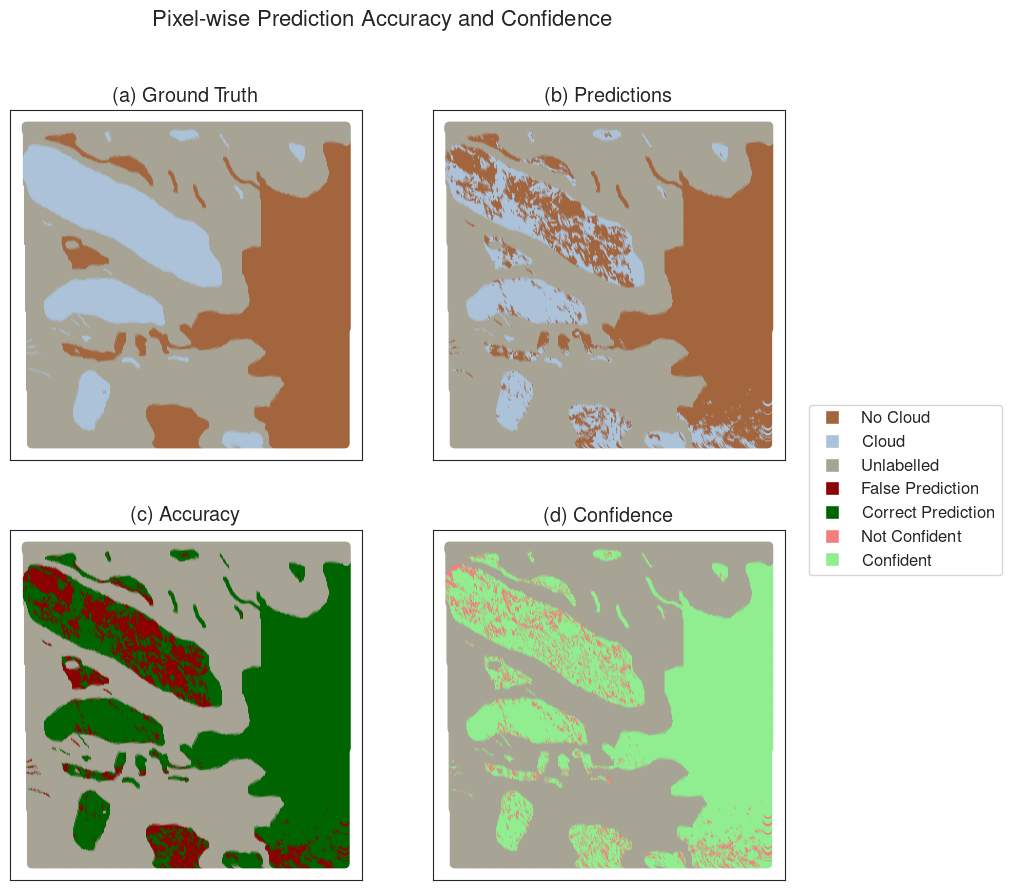

In [72]:
# Define color maps
label_color_map = {-1: "xkcd:earth", 1: "xkcd:cloudy blue", 0: "xkcd:greyish"}
error_color_map = {-1: "darkred", 1: "darkgreen", 0: "xkcd:greyish"}
confident_color_map = {-1: "lightcoral", 1: "lightgreen", 0: "xkcd:greyish"}

# Plot ground truth, predictions, errors and confidence
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(data=predictions_all, x="x", y="y", hue="label", 
                palette=label_color_map, ax=axs[0, 0], edgecolor="none")

hue_preds_only_labeled = [pred if label != 0 else 0 
                          for pred, label in zip(predictions_all["pred"], predictions_all["label"])]
sns.scatterplot(data=predictions_all, x="x", y="y", hue=hue_preds_only_labeled, 
                palette=label_color_map, ax=axs[0, 1], edgecolor="none")

hue_error = [0 if label == 0 else 1 if pred == label else -1 for pred, label in zip(predictions_all["pred"], predictions_all["label"])]
sns.scatterplot(data=predictions_all, x="x", y="y", hue=hue_error, 
                palette=error_color_map, ax=axs[1, 0], edgecolor="none")

hue_is_confident = [0 if label == 0 else -1 if pred > 0.4 and pred < 0.6 else 1 for pred, label in zip(predictions_all["pred_prob"], predictions_all["label"])]
sns.scatterplot(data=predictions_all, x="x", y="y", hue=hue_is_confident,
                palette=confident_color_map, ax=axs[1, 1], edgecolor="none")

# Remove axis labels
for i in range(2):
    for j in range(2):
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xlabel(None)
        axs[i, j].set_ylabel(None)
        # Remove legend from each subplot
        axs[i, j].get_legend().remove()
    
# Add titles
axs[0, 0].set_title("(a) Ground Truth")
axs[0, 1].set_title("(b) Predictions")
axs[1, 0].set_title("(c) Accuracy")
axs[1, 1].set_title("(d) Confidence")
# Add global title
fig.suptitle("Pixel-wise Prediction Accuracy and Confidence", fontsize=16)
# Add global legend for labels, errors and confidence, for errors and confidence, only show for labeled pixels
label_handles = [plt.Line2D([0], [0], marker="s", color="w", markerfacecolor=color, markersize=10, label=label)
                    for label, color in label_color_map.items()]
error_handles = [plt.Line2D([0], [0], marker="s", color="w", markerfacecolor=color, markersize=10, label=label)
                 for label, color in ((-1, "darkred"), (1, "darkgreen"))]
confident_handles = [plt.Line2D([0], [0], marker="s", color="w", markerfacecolor=color, markersize=10, label=label)
                        for label, color in ((-1, "lightcoral"), (1, "lightgreen"))]

all_handles = label_handles + error_handles + confident_handles
all_labels = ["No Cloud", "Cloud", "Unlabelled", "False Prediction", "Correct Prediction", "Not Confident", "Confident"]
fig.legend(handles=all_handles, labels=all_labels, loc="center right", bbox_to_anchor=(1.125, 0.5))
plt.savefig("../../figs/error_analysis.pdf", bbox_inches="tight")
plt.show()